In [1]:
#REFERENCES

# Kaggle tutorial: 
# https://www.youtube.com/watch?v=mPFq5KMxKVw

# Keras 
# https://keras.io/api/applications/mobilenet/

# Andrew Yang
# https://www.youtube.com/watch?v=yofjFQddwHE

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import  plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from PIL import Image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=26x37 at 0x7FC8DEBDE450>
H:  26 W:  37


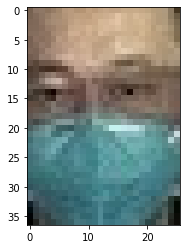

In [3]:
# initialize 

INIT_LRATE = 1e-4
EPOCHS = 12
BATCHSIZE = 32

DIRECTORY = "/Users/sashanksilwal/Downloads/Face-Mask-Detection/dataset/"
CATEGORIES = ["with_mask", "without_mask"]


data = []
labels = []
img_ = []
all_path = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, str(category))
    for img in os.listdir(path):
        
        img_path = os.path.join(path, img)
        all_path.append(img_path)
        img_.append((mpimg.imread(img_path)).size)


smallestimg = Image.open(all_path[img_.index(np.min(img_))])
print(smallestimg)
plt.imshow(smallestimg)
height, width = smallestimg.size

print("H: ",height,"W: ",width)


In [4]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)





/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [7]:

# construct the training image generator 
train_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [8]:
#imports the mobilenet model and discards the last 1000 neuron layer. # include top= false exclude the last layer

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


# construct the head of the model 
xModel = baseModel.output
xModel = AveragePooling2D(pool_size=(7, 7))(xModel)
xModel = Flatten(name="flatten")(xModel)
xModel = Dense(128, activation="relu")(xModel)
xModel = Dropout(0.5)(xModel)
xModel = Dense(2, activation="softmax")(xModel)


model = Model(inputs=baseModel.input, outputs=xModel)

# loop over all layers in the base model and freeze them already pretrained
for layer in baseModel.layers:
    layer.trainable = False



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

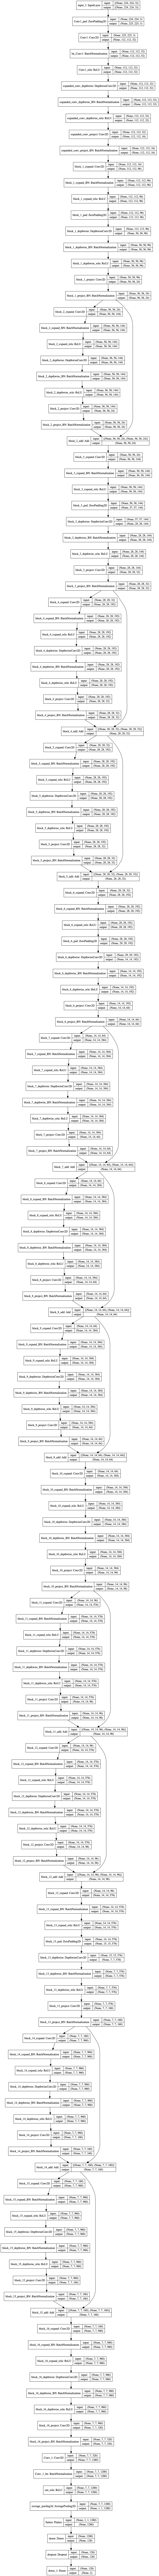

In [9]:
# for i,layer in enumerate(model.layers):
#     print(i,layer.name)
model.summary()
plot_model(model, to_file="model.png", show_shapes = True)

In [10]:
# compiling the model

optimizer_ = Adam(lr=INIT_LRATE, decay=INIT_LRATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimizer_, metrics=["accuracy"])



In [11]:
def plots(ims, figsize=(90,90), rows=3, interp=False, titles=None):
    
    
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        
        
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
            
            
    f = plt.figure(figsize=figsize)
    
    
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    
    for i in range(len(ims)):
        sp = f.add_subplot(6, 6, i+1)
        
        sp.axis('Off')
        
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

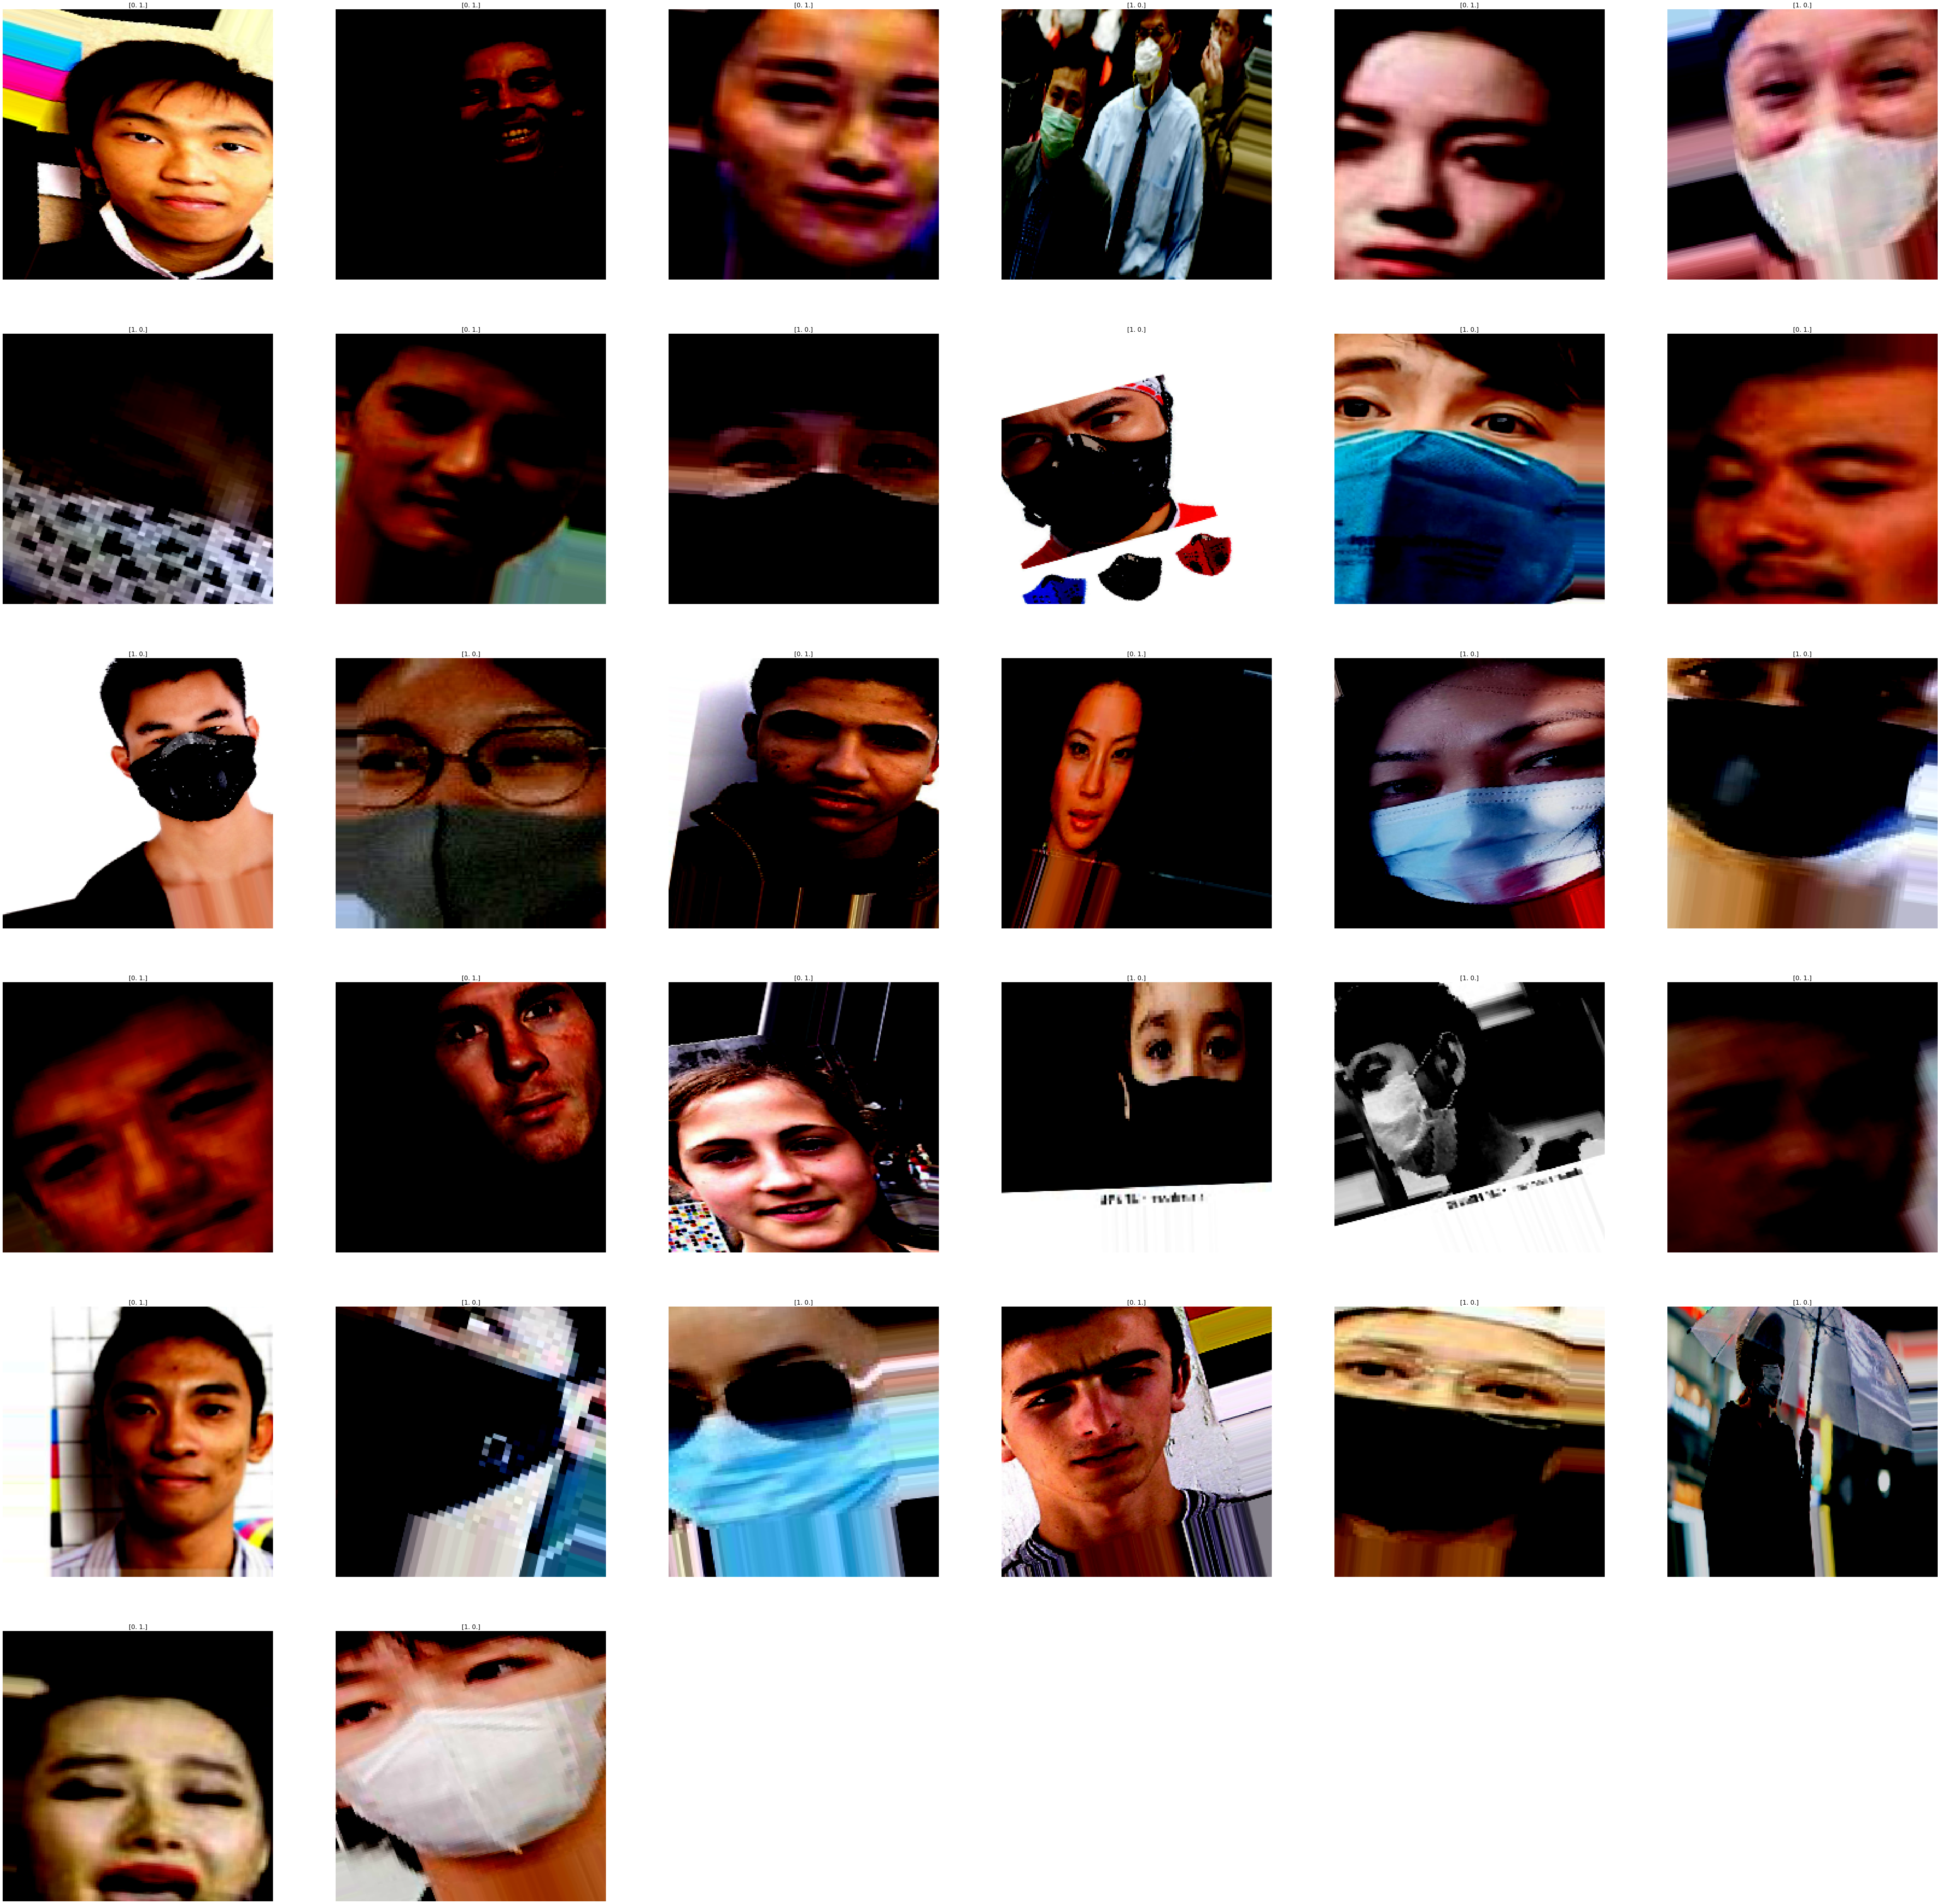

In [12]:
train_batches = train_generator.flow(trainX, trainY, batch_size=BATCHSIZE)

imgs, labels = next(train_batches)

plots(imgs, titles=labels)

In [11]:
# train the head of the network
H = model.fit(
    train_generator.flow(trainX, trainY, batch_size=BATCHSIZE),
    steps_per_epoch=len(trainX) // BATCHSIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCHSIZE,
    epochs=EPOCHS)



Epoch 1/12
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
95/95 [==============================] - 284s 3s/step - loss: 0.5600 - acc: 0.7235 - val_loss: 0.3706 - val_acc: 0.8514
Epoch 2/12
95/95 [==============================] - 209s 2s/step - loss: 0.3034 - acc: 0.8761 - val_loss: 0.2630 - val_acc: 0.8970
Epoch 3/12
95/95 [==============================] - 197s 2s/step - loss: 0.2523 - acc: 0.9021 - val_loss: 0.2074 - val_acc: 0.9126
Epoch 4/12
95/95 [==============================] - 230s 2s/step - loss: 0.2091 - acc: 0.9209 - val_loss: 0.2082 - val_acc: 0.9113
Epoch 5/12
95/95 [==============================] - 220s 2s/step - loss: 0.1721 - acc: 0.9367 - val_loss: 0.2018 - val_acc: 0.9153
Epoch 6/12
95/95 [==============================] - 220s 2s/step - loss: 0.1446 - acc: 0.9450 - val_loss: 0.2381 - val_acc: 0.9113
Epoch 7/12
95/95 [==============================] - 212s 2s/step - loss: 0.1394 - acc: 0.9489 - val_loss: 0.2129 - val_a

In [14]:
# make predictions on the testing set
predictI = model.predict(testX, batch_size=BATCHSIZE)


In [13]:
# find the index of the label with corresponding largest predicted probability

predictI = np.argmax(predictI, axis=1)

# classification report
print(classification_report(testY.argmax(axis=1), predictI,
    target_names=lb.classes_))



              precision    recall  f1-score   support

   with_mask       0.99      0.85      0.92       383
without_mask       0.87      0.99      0.93       384

    accuracy                           0.92       767
   macro avg       0.93      0.92      0.92       767
weighted avg       0.93      0.92      0.92       767



In [14]:
# saving the model to disk
model.save("mask_detectorMNet.model", save_format="h5")

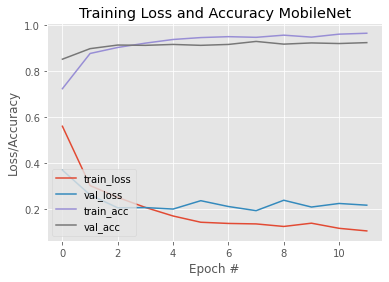

In [42]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy MobileNet")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotMobileNet.png")
plt.show()

In [17]:
# Our class labels are currently represented as strings; however, Keras will assume that both:

    # Labels are encoded as integers
    
    # And furthermore, one-hot encoding is performed on these labels making each label 
        # represented as a vector rather than an integer